# Twitter author prediction

## Prerequisites

### Importing necessary libraries

In [103]:
import random; random.seed(53)
import pandas as pd

# Import all we need from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt

A következő csak egy segédfüggvény, ami majd később segít megjeleníteni a confusion mátrixot.

In [104]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



### Load the data

In [105]:
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets_1.csv")
#extract the texts and the authors where the author is either HillaryClinton or realDonaldTrump
tweet_df = tweet_df[tweet_df.is_retweet == False]
tweet_df = tweet_df[["handle", "text"]]
tweet_df.columns = ["author", "status"]


Az eredeti adatbázisban voltak tweetek és retweetek is, de mi csak a tweeteket használjuk fel. Tehát a felhasznált oszlopok a következőképpen néznek ki:

In [106]:
tweet_df.head()

,author,status
0,HillaryClinton,The question in this election: Who can put the...
3,HillaryClinton,"If we stand together, there's nothing we can't..."
4,HillaryClinton,Both candidates were asked about how they'd co...
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...
6,HillaryClinton,This election is too important to sit out. Go ...


A következő sorokban szétbontjuk az adatbázist train és test részekre.  
A train rész lesz az, amit felhasználunk a modell tanításához, a test pedig a modell teszteléséhez. Ami érdekes beállítás, hogy a train_test_split függvényben a stratify paramétert a címkére állítjuk, így biztosítva, hogy a train és test részekben is ugyanolyan arányban legyenek a címkék.  
A test_size paraméterrel pedig azt állítjuk be, hogy a teljes adatbázis 10%-át használjuk fel tesztelésre. Ez elsőre alacsonynak tűnhet, de a train seten is cross validationt fogunk használni, az overfittinget elkerülendő. _Később meglátjuk, hogy ez mennyire volt jó döntés._

In [107]:
# Create target
y = tweet_df["author"]
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    tweet_df["status"], y,  test_size=0.1, stratify=y, random_state=42)

## Data cleaning

Ebben a részben a tweeteket tokenné alakítjuk két különböző módszerrel. Az egyik módszer a CountVectorizer, a másik pedig a TfidfVectorizer. A kettő közötti különbség, hogy a CountVectorizer csak a szavak előfordulását számolja, míg a TfidfVectorizer a szavak előfordulását szorozza a szavak inverse document frequency-jével. Az inverse document frequency azt mutatja meg, hogy egy szó mennyire jellemző egy adott dokumentumra. Tehát ha egy szó gyakran előfordul egy dokumentumban, akkor az inverse document frequency-je alacsony lesz, mert nem jellemző a dokumentumra.  
__Lényegében tehát a TfidfVectorizer a CountVectorizer egy fejlettebb változata, ami a gyakran előforduló szavakat alulreprezentálja, a ritka szavakat pedig felül.__

### CountVectorizer

In [108]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.01, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

Itt beállítjuk, hogy mekkora legyen a minimum és a maximum előfordulás, amit még figyelembe veszünk. A stop_words paraméterrel pedig azt állítjuk be, hogy milyen szavakat ne vegyen figyelembe a CountVectorizer. Ezek a szavak általában nem sokatmondóak a modellek szempontjából, mint például a névelők, elöljárószók, stb.

Egyébként itt egy óriási sparse matrixot kapunk, de ezt jól kezeli a python.  
Ilyen szavakat kapunk:

In [109]:
print(count_vectorizer.vocabulary_)

{'look': 57, 'amp': 6, 'party': 74, 'makeamericagreatagain': 60, 'https': 43, 'let': 52, 'make': 59, 'family': 34, 'america': 2, 'people': 76, 'right': 85, 'want': 114, 'thank': 99, 've': 110, 'campaign': 13, 'donald': 29, 'trump': 107, 'tax': 97, 'plan': 77, 'national': 68, 'years': 126, 'proud': 81, 'tonight': 105, 'women': 120, 'million': 64, 'vote': 111, 'today': 103, 'new': 70, 'york': 127, 'hillary': 41, 'know': 51, 'like': 54, 'trump2016': 108, 'join': 49, 'clinton': 18, 'candidate': 14, 'says': 89, 'country': 20, 'president': 80, 'obama': 73, 'american': 4, 'economy': 30, 'americans': 5, 'realdonaldtrump': 82, 'man': 62, 'good': 37, 'wants': 115, 'great': 39, 'making': 61, 'things': 100, 'watch': 116, 'votetrump': 112, 'night': 72, 'said': 87, 'work': 122, 'change': 17, 'really': 83, 'amazing': 1, 'ted': 98, 'cruz': 23, 'win': 118, 'doesn': 27, 'stop': 94, 'time': 102, 'money': 66, 'won': 121, 'support': 95, 'foxnews': 35, 'history': 42, 'united': 109, 'states': 93, 'don': 28, 

### Tf-Idf

In [110]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

Itt ugyanazt tudjuk elmondani a paraméterekről, mint a CountVectorizer esetében.  
A kapott szavak persze ugyanazok, de a sparse mátrixban nem a darabszámuk szerepel, hanem az inverse document frequency-jük.

In [111]:
print(tfidf_vectorizer.vocabulary_)

{'look': 57, 'amp': 6, 'party': 74, 'makeamericagreatagain': 60, 'https': 43, 'let': 52, 'make': 59, 'family': 34, 'america': 2, 'people': 76, 'right': 85, 'want': 114, 'thank': 99, 've': 110, 'campaign': 13, 'donald': 29, 'trump': 107, 'tax': 97, 'plan': 77, 'national': 68, 'years': 126, 'proud': 81, 'tonight': 105, 'women': 120, 'million': 64, 'vote': 111, 'today': 103, 'new': 70, 'york': 127, 'hillary': 41, 'know': 51, 'like': 54, 'trump2016': 108, 'join': 49, 'clinton': 18, 'candidate': 14, 'says': 89, 'country': 20, 'president': 80, 'obama': 73, 'american': 4, 'economy': 30, 'americans': 5, 'realdonaldtrump': 82, 'man': 62, 'good': 37, 'wants': 115, 'great': 39, 'making': 61, 'things': 100, 'watch': 116, 'votetrump': 112, 'night': 72, 'said': 87, 'work': 122, 'change': 17, 'really': 83, 'amazing': 1, 'ted': 98, 'cruz': 23, 'win': 118, 'doesn': 27, 'stop': 94, 'time': 102, 'money': 66, 'won': 121, 'support': 95, 'foxnews': 35, 'history': 42, 'united': 109, 'states': 93, 'don': 28, 

## Training the models

Ebben a fejezetben definiáljuk a felhasznált modelleket, és tanítjuk is őket.

A CountVectorizerrel kapott adatokat nem használjuk fel, csak a TfidfVectorizerrel kapottakat. Ennek egyszerű oka, hogy mindig jobban teljesít a TfidfVectorizerrel kapott adatokon tanított modell, mint a CountVectorizerrel kapott adatokon tanított modell.

Minden modell esetében a következő lépések történnek:
1. A modell létrehozása
2. Modell lehetséges hiperparamétereinek megadása
3. A hiperparaméterek terén egy cross validációs optimalizáció futtatása (azaz végigmegyünk az összes lehetséges hiperparaméter kombináción, amit megadtunk, és megnézzük, hogy melyik kombináció adja a legjobb eredményt).  
Ezt lehetne randomizálni, de felesleges, így is lefutnak másodpercek alatt a tanulások.
1. A legjobb hiperparaméterekkel új modell létrehozása, ezekkel fogjuk kiértékelni a modellt a test seten.

Minden modell alatt ki lesz írva, hogy a legjobb estimator milyen hiperparaméterekkel rendelkezik.

_Megjegyzés 1: Ezért nem gond, hogy 90%-os nagyságú a train setünk, mert még ezen belül is cross validációt használunk._

_Megjegyzés 2: A hiperparaméterek terét erősebb géppel nagyobbnak is lehetne állítani, de ezek így még a legtöbb gépen elfutnak._

### Training a multinomial naive Bayes model

Először egy multinomiális naív Bayes modellt alkotunk. 

Itt a következő hiperparamétereket állítjuk be:
- __alpha__: ez egy smoothing paraméter, ami azt szabályozza, hogy mennyire legyenek simák a döntési határok. Ha ez a paraméter 0, akkor a modell nem fogja tudni kezelni azokat a szavakat, amiket a tanító adatbázisban nem látott. Ha ez a paraméter túl nagy, akkor pedig a modell túl sima lesz, és semmitmondó eredményeket fogunk kapni.
- __fit_prior__: ez egy boolean, ami azt szabályozza, hogy a modellnek legyenek-e saját priorjai, vagy pedig a tanító adatbázisban látott előfordulások alapján számolja ki a priorokat.

In [112]:
# Create and fit the model for the tf-idf data
param_grid_nb = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
tf_idf_nb_cv = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
tf_idf_nb_cv.fit(tfidf_train, y_train)
tf_idf_nb = tf_idf_nb_cv.best_estimator_
tf_idf_nb_pred = tf_idf_nb.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_nb_cv.best_params_))


Best parameters: {'alpha': 10.0, 'fit_prior': True}


### Training an SVM model

Itt az SVM-ek legegyszerűbb változatát használjuk, a lineáris support vector machine-t.  
A következő hiperparamétereket állítjuk be:
- __C__: ez egy regularization paraméter, ami azt szabályozza, hogy mennyire legyenek simák a döntési határok. Ha ez a paraméter túl nagy, akkor a modell túl sima lesz, és semmitmondó eredményeket fogunk kapni. Ha túl kicsi, akkor pedig a modell túl zajos lesz, és overfitteléshez vezethet. _Gyakorlatiliag a hipersík elhelyezkedését szabályozza a pontokhoz képest, minél kisebb a C, annál jobban bűnteti a hipersíkhoz közeli ponotokat._
- __dual__: Ez csak a megoldási algoritmusra van hatással, azt mutatja, hogy az optimalizálási feladat primál vagy duál feladatát oldja-e meg az algoritmus. Lehet, hogy közelítési hibák miatt van különbség a kettő között, ezért erre a paraméterre is optimalizálunk, persze ez nem lenne szükséges.

In [113]:
param_grid_svc = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "dual": [True, False],
}
tf_idf_svc_cv = GridSearchCV(LinearSVC(), param_grid=param_grid_svc, cv=5)
tf_idf_svc_cv.fit(tfidf_train, y_train)
tf_idf_svc_pred = tf_idf_svc_cv.predict(tfidf_test)
tf_idf_svc = tf_idf_svc_cv.best_estimator_
print("Best parameters: {}".format(tf_idf_svc_cv.best_params_))



Best parameters: {'C': 0.01, 'dual': True}


Fontos megjegyezni, hogy itt a legkevésbé sem használtuk ki az SVM-ekben rejlő potenciált, mivel csak egy lineáris SVM-et használtunk, ami nem tud nem lineárisan szeparálható adatokon tökéletesen teljesíteni.

### Training a logistic regression model

Itt egy logisztikus regressziós modellt használunk.

A hiperparaméter a következő:
- __C__: Ez is egy regulizációs paraméter, ami bünteti a nagyobb paramétereket. Ezt is persze az overfitting elkerülése végett használjuk.

In [114]:
param_grid_lr = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}
tf_idf_lr_cv = GridSearchCV(LogisticRegression(), param_grid=param_grid_lr, cv=5)
tf_idf_lr_cv.fit(tfidf_train, y_train)
tf_idf_lr = tf_idf_lr_cv.best_estimator_
tf_idf_lr_pred = tf_idf_lr.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_lr_cv.best_params_))

Best parameters: {'C': 1}


### Training a decision tree model

Döntési fa, na itt már izgalmasabb hiperparaméterek is vannak.

- __criterion__: Ez a módszer, ami alapján az egyes spliteket csinálja az algoritmus. Kettőt próbáltunk, a ginit és az entropyt.
- __max_depth__: Ez a paraméter azt szabályozza, hogy milyen mély legyen maximálisan a döntési fa. Ha túl nagy, akkor overfitteléshez vezethet, ha túl kicsi, akkor pedig nem lesz elég pontos a modell.
- __min_samples_leaf__: Ez a paraméter azt szabályozza, hogy egy levélben hány elem legyen minimum. Ha túl kicsi, akkor overfitteléshez vezethet, ha túl nagy, akkor pedig nem lesz elég pontos a modell.

In [115]:
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8]
}
tf_idf_dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5, n_jobs=-1)
tf_idf_dt_cv.fit(tfidf_train, y_train)
tf_idf_dt = tf_idf_dt_cv.best_estimator_
tf_idf_dt_pred = tf_idf_dt.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_dt_cv.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2}


### Training a random forest model

Na itt már maga a modell is érdekesebb, ugyanis ez egy bagginges random forest modell.  
Itt tehát folyamatosan bootsrappeljük nemcsak a megfigyeléseket, hanem a feature-öket is.

A hiperparaméterek a következők:
- __n_estimators__: Ez a paraméter azt szabályozza, hogy hány döntési fát használjunk a modellben. Minél többet használunk, annál pontosabb lesz a modell, de annál több erőforrást is fog igénybe venni.
- __max_samples__: Ez a paraméter azt szabályozza, hogy egy döntési fa mennyi megfigyelést használjon fel a tanuláshoz. Minél többet használunk, annál pontosabb lesz a modell, de annál több erőforrást is fog igénybe venni. (itt, ha floatot adunk meg, akkor az összes megfigyelés 80%-át használja fel a tanuláshoz)
- __max_features__: Ez a paraméter azt szabályozza, hogy egy döntési fa mennyi feature-t használjon fel a tanuláshoz. Minél többet használunk, annál pontosabb lesz a modell, de annál több erőforrást is fog igénybe venni. (itt, ha floatot adunk meg, akkor az összes változó (token) 80%-át használja fel a tanuláshoz)
- __random_state__: ez egy seed állítás, hogy reprodukálható eredményeket kapjunk.
- __n_jobs__: ez a paraméter azt szabályozza, hogy hány magot használjon fel a gép a modell tanításához. Ha -1-et adunk meg, akkor az összes magot felhasználja.

In [116]:
tf_idf_rf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, max_features=0.8, random_state=42, n_jobs=-1)
tf_idf_rf.fit(tfidf_train, y_train)
tf_idf_rf_pred = tf_idf_rf.predict(tfidf_test)

## Accuracy scores (for the tf-idf vectorizer)

In [117]:
target_values = list(tf_idf_lr.classes_)
target_values

['HillaryClinton', 'realDonaldTrump']

### Confusion matrices

In [118]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values, normalize='true')
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values, normalize='true')
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values, normalize='true')
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values, normalize='true')
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values, normalize='true')

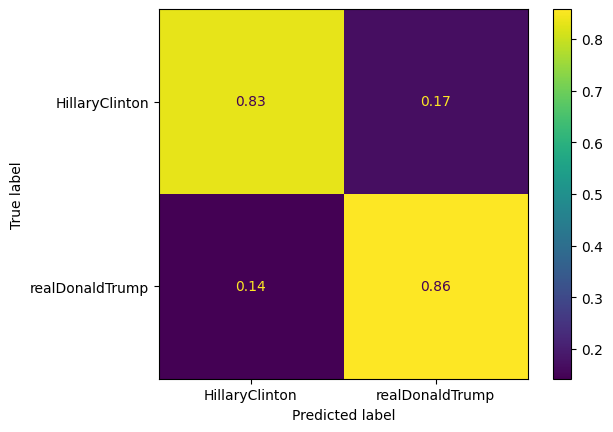

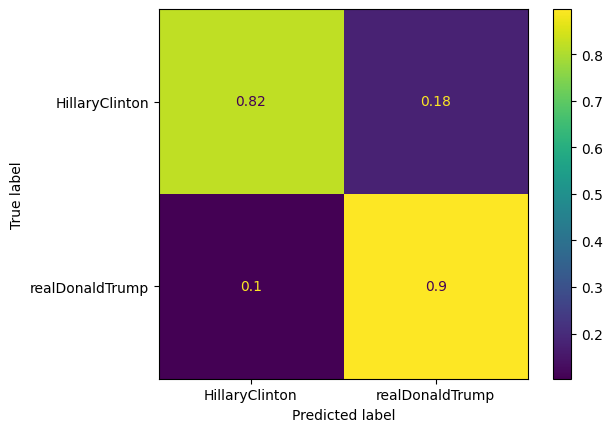

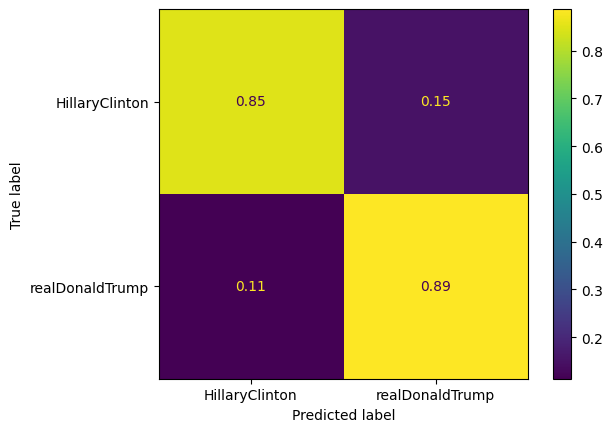

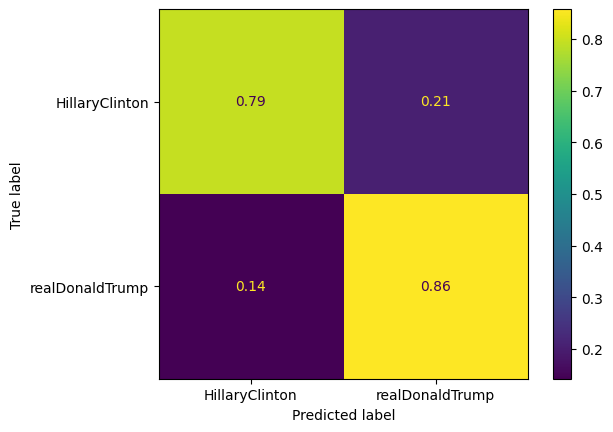

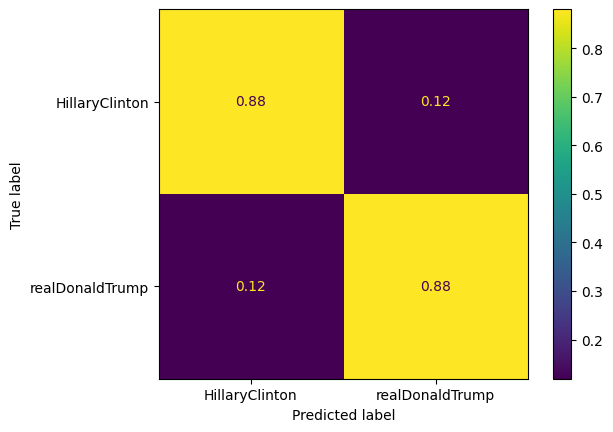

In [119]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

### Accuracy scores of the models (on the test set)

In [120]:
print("Naive Bayes\t\t", tf_idf_nb.score(tfidf_test, y_test))
print("SVC\t\t\t", tf_idf_svc.score(tfidf_test, y_test))
print("Logistic Regression\t", tf_idf_lr.score(tfidf_test, y_test))
print("Decision Tree\t\t", tf_idf_dt.score(tfidf_test, y_test))
print("Random Forest\t\t", tf_idf_rf.score(tfidf_test, y_test))

Naive Bayes		 0.8464223385689355
SVC			 0.8621291448516579
Logistic Regression	 0.8691099476439791
Decision Tree		 0.8289703315881326
Random Forest		 0.8795811518324608


### Cross-validation (on the training set)

In [121]:
print(f"Naive Bayes:\t\t{tf_idf_nb_cv.best_score_}")
print(f"SVC:\t\t\t{tf_idf_svc_cv.best_score_}")
print(f"Logistic Regression:\t{tf_idf_lr_cv.best_score_}")
print(f"Decision Tree:\t\t{tf_idf_dt_cv.best_score_}")
print(f"Random Forest:\t\tNo cross validation performed") # BaggingClassifier does not support cross validation

Naive Bayes:		0.8283149820260975
SVC:			0.8522043269457574
Logistic Regression:	0.8518159774311945
Decision Tree:		0.8195761744364874
Random Forest:		No cross validation performed


### Recall scores of the models

In [122]:
print("Naive Bayes".ljust(20), metrics.recall_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.recall_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.recall_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.recall_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.recall_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.8326996197718631
SVC                  0.8212927756653993
Logistic Regression  0.8479087452471483
Decision Tree        0.7946768060836502
Random Forest        0.8783269961977186


### Precision scores of the models

In [123]:
print("Naive Bayes".ljust(20), metrics.precision_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.precision_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.precision_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.precision_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.precision_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.8326996197718631
SVC                  0.8709677419354839
Logistic Regression  0.8643410852713178
Decision Tree        0.8260869565217391
Random Forest        0.8619402985074627


### f1-scores of the models

In [124]:
print("Naive Bayes".ljust(20), metrics.f1_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.f1_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.f1_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.f1_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.f1_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.832699619771863
SVC                  0.8454011741682974
Logistic Regression  0.8560460652591172
Decision Tree        0.8100775193798451
Random Forest        0.8700564971751411


### Classification reports

In [125]:
# classification report
report_nb = metrics.classification_report(y_test, tf_idf_nb_pred, labels=target_values, output_dict=True)
report_svm = metrics.classification_report(y_test, tf_idf_svc_pred, labels=target_values, output_dict=True)
report_lr = metrics.classification_report(y_test, tf_idf_lr_pred, labels=target_values, output_dict=True)
report_dt = metrics.classification_report(y_test, tf_idf_dt_pred, labels=target_values, output_dict=True)
report_rf = metrics.classification_report(y_test, tf_idf_rf_pred, labels=target_values, output_dict=True)


df_nb = pd.DataFrame.from_dict(report_nb).transpose()
df_svm = pd.DataFrame.from_dict(report_svm).transpose()
df_lr = pd.DataFrame.from_dict(report_lr).transpose()
df_dt = pd.DataFrame.from_dict(report_dt).transpose()
df_rf = pd.DataFrame.from_dict(report_rf).transpose()

report_dict = {
    "Naive Bayes": df_nb,
    "SVM": df_svm,
    "Logistic Regression": df_lr,
    "Decision Tree": df_dt,
    "Random Forest": df_rf
}

for model, report in report_dict.items():
    print(model)
    print(report)
    print("\n")

Naive Bayes
                 precision    recall  f1-score     support
HillaryClinton    0.832700  0.832700  0.832700  263.000000
realDonaldTrump   0.858065  0.858065  0.858065  310.000000
accuracy          0.846422  0.846422  0.846422    0.846422
macro avg         0.845382  0.845382  0.845382  573.000000
weighted avg      0.846422  0.846422  0.846422  573.000000


SVM
                 precision    recall  f1-score     support
HillaryClinton    0.870968  0.821293  0.845401  263.000000
realDonaldTrump   0.855385  0.896774  0.875591  310.000000
accuracy          0.862129  0.862129  0.862129    0.862129
macro avg         0.863176  0.859033  0.860496  573.000000
weighted avg      0.862537  0.862129  0.861734  573.000000


Logistic Regression
                 precision    recall  f1-score    support
HillaryClinton    0.864341  0.847909  0.856046  263.00000
realDonaldTrump   0.873016  0.887097  0.880000  310.00000
accuracy          0.869110  0.869110  0.869110    0.86911
macro avg         0.

### Roc-auc scores of the models

In [126]:
print("Naive Bayes".ljust(20), metrics.roc_auc_score(y_test, tf_idf_nb.predict_proba(tfidf_test)[:,1]))
print("SVC does not support predict_proba")
print("Logistic Regression".ljust(20), metrics.roc_auc_score(y_test, tf_idf_lr.predict_proba(tfidf_test)[:,1]))
print("Decision Tree".ljust(20), metrics.roc_auc_score(y_test, tf_idf_dt.predict_proba(tfidf_test)[:,1]))
print("Random Forest".ljust(20), metrics.roc_auc_score(y_test, tf_idf_rf.predict_proba(tfidf_test)[:,1]))

Naive Bayes          0.922758493805961
SVC does not support predict_proba
Logistic Regression  0.9346436894394701
Decision Tree        0.8495277811848401
Random Forest        0.9503618300012265
